In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import gc
import warnings
from joblib import dump, load
warnings.filterwarnings('ignore')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim
from gensim.models import Word2Vec

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [4]:
def load_data():
    data = pd.read_csv('cleaned_data.csv', names=['Review','Sentiment','Sentence_Removal','Lower_Case','Sen_Out_StopWord','stem'])
    return data

In [5]:
roman_urdu_df= load_data()
roman_urdu_df.head()

,Review,Sentiment,Sentence_Removal,Lower_Case,Sen_Out_StopWord,stem
0,Reviews,Sentiment,Sentence_Removal,Lower_Case,Sen_Out_StopWord,stem
1,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,Sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha her kisi kay bus bat nhi lakin ki hal ...,sae qa er qisi qay bos bat ni laqin qi al qal ...
2,sahi bt h,Positive,sahi bt h,sahi bt h,sahi bt h,sai bt
3,"Kya bt hai,",Positive,Kya bt hai,kya bt hai,bt,bt
4,Wah je wah,Positive,Wah je wah,wah je wah,wah je wah,wa je wa


In [6]:
roman_urdu_df = roman_urdu_df.drop(roman_urdu_df.index[0])
roman_urdu_df = roman_urdu_df.reset_index(drop=True)
roman_urdu_df.head()

,Review,Sentiment,Sentence_Removal,Lower_Case,Sen_Out_StopWord,stem
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,Sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha her kisi kay bus bat nhi lakin ki hal ...,sae qa er qisi qay bos bat ni laqin qi al qal ...
1,sahi bt h,Positive,sahi bt h,sahi bt h,sahi bt h,sai bt
2,"Kya bt hai,",Positive,Kya bt hai,kya bt hai,bt,bt
3,Wah je wah,Positive,Wah je wah,wah je wah,wah je wah,wa je wa
4,Are wha kaya bat hai,Positive,Are wha kaya bat hai,are wha kaya bat hai,are wha kaya bat,are wa qaya bat


In [13]:
print(roman_urdu_df.isna().any())

Review              False
Sentiment           False
Sentence_Removal     True
Lower_Case           True
Sen_Out_StopWord     True
stem                 True
dtype: bool


In [15]:
roman_urdu_df=roman_urdu_df.dropna()
print(roman_urdu_df.isna().any())

Review              False
Sentiment           False
Sentence_Removal    False
Lower_Case          False
Sen_Out_StopWord    False
stem                False
dtype: bool


In [16]:
def generateWordCloudForClusters(n_clusters,clustermTerms):
    termListerOfSeprateCluster=[]
    for clusterno in range(n_clusters):
        for i in (clustermTerms):
            if(clusterno == i.get('cluster')):
                terms = i.get('terms')
                termListerOfSeprateCluster.append((terms))
        print(termListerOfSeprateCluster)
        wordcloud = WordCloud(width = 500, height = 500, background_color='black', random_state=10).generate(transformForWordCount(termListerOfSeprateCluster))
        plot_cloud(wordcloud)
        termListerOfSeprateCluster = []

def transformForWordCount(terms):
    cloud = []
    for term in range(len(terms)):
        cloud.append(terms[term])
    return " ".join(cloud)
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off");

In [17]:
from sklearn.model_selection import train_test_split

train_features,test_features, train_target, test_target = train_test_split(roman_urdu_df['stem'], roman_urdu_df['Sentiment'],
                                                          random_state=42,
                                                          test_size=0.2)


Count Vectorizer

In [20]:
count_vectorizer = CountVectorizer(lowercase=False, stop_words=None, ngram_range=(1,3))
bow = count_vectorizer.fit_transform(train_features)
dump(count_vectorizer, 'count_vectorizer_model.joblib')
bow.shape

(27149, 470180)

Tf-idf

In [21]:
tfidf =TfidfVectorizer(stop_words=None, ngram_range=(1,3))
tfidf_features = tfidf.fit_transform(train_features)
dump(tfidf, 'tfidf_vectorizer_model.joblib')
tfidf_features.shape

(27149, 470180)

Word2Vec

In [22]:
train_features_w2v = train_features.reset_index()['stem']
test_features_w2v = test_features.reset_index()['stem']
tokenized_train_features_w2v = train_features_w2v.apply(lambda x:x.split())
tokenized_test_features_w2v = test_features_w2v.apply(lambda x:x.split())
word2vec_model = Word2Vec(
                                       tokenized_train_features_w2v,
                                       vector_size = 200, #desired number of features/ independent variables for each word
                                       window = 5,  #context window size
                                       min_count = 5,
                                       sg = 1, #skip gram model
                                       hs = 0,
                                       negative = 10,  #negative sampling
                                       workers = 4,
                                       seed = 34
                                       )

word2vec_model.train(tokenized_train_features_w2v, total_examples=len(train_features_w2v), epochs=20)
word2vec_model.save("word2vec_model")

word_vectors = word2vec_model.wv
word_vectors.save("word_vectors.kv")

Doc2Vec

In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
import numpy as np

# Assuming tokenized_train_features_w2v and tokenized_test_features_w2v are lists of sentences
tokenized_train_features_w2v = [' '.join(sentence) for sentence in tokenized_train_features_w2v]
tokenized_test_features_w2v = [' '.join(sentence) for sentence in tokenized_test_features_w2v]

# Now, tokenized_train_features_w2v and tokenized_test_features_w2v are lists of strings

# Continue with the TaggedDocument creation
tagged_train_data = [TaggedDocument(words=word_tokenize(sentence), tags=[str(i)]) for i, sentence in enumerate(tokenized_train_features_w2v)]
tagged_test_data = [TaggedDocument(words=word_tokenize(sentence), tags=[str(i)]) for i, sentence in enumerate(tokenized_test_features_w2v)]
# Initialize and train the Doc2Vec model
doc2vec_model = Doc2Vec(
    vector_size=200,  # Size of the output vectors
    window=5,
    min_count=2,
    workers=2,
    epochs=20
)

# Build the vocabulary
doc2vec_model.build_vocab(tagged_train_data)

# Train the model
doc2vec_model.train(tagged_train_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Save the trained model
doc2vec_model.save("Doc2Vec_model")

# Get sentence vectors for train and test sets
train_sentence_vectors = np.array([doc2vec_model.infer_vector(word_tokenize(sentence)) for sentence in tokenized_train_features_w2v])
test_sentence_vectors = np.array([doc2vec_model.infer_vector(word_tokenize(sentence)) for sentence in tokenized_test_features_w2v])


In [27]:
train_sentence_vectors

array([[ 0.00522231, -0.02738305, -0.01934027, ...,  0.02487318,
        -0.03469143,  0.02675257],
       [-0.01007788,  0.07382778,  0.02494571, ...,  0.05041074,
         0.00885242,  0.00175718],
       [ 0.01987694, -0.01046612, -0.01872256, ...,  0.02202375,
         0.03908313,  0.00462122],
       ...,
       [ 0.04964953,  0.03315032, -0.04300547, ..., -0.06770737,
         0.03177095,  0.03034874],
       [ 0.01815577,  0.0283645 ,  0.05081709, ...,  0.070305  ,
        -0.00189479,  0.01149882],
       [-0.01425223, -0.00519119,  0.02224007, ...,  0.00873804,
         0.00903629,  0.01181686]], dtype=float32)

In [28]:
def word_vector(tokens, size):
    vec,count = np.zeros(size).reshape((1, size)),0
    for word in tokens:
        try:
            vec += word2vec_model.wv[word].reshape((1, size))
            count += 1
        except KeyError: # handling the case where the token is not in the vocabulary
            continue

    if count != 0:
        vec /= count
    return vec

In [29]:
train_array_w2v = np.zeros((len(tokenized_train_features_w2v), 200))

for i in range(len(tokenized_train_features_w2v)):
    train_array_w2v[i,:] = word_vector(tokenized_train_features_w2v[i], 200)

train_features_w2v=pd.DataFrame(train_array_w2v)

In [30]:
test_array_w2v = np.zeros((len(tokenized_test_features_w2v), 200))

for i in range(len(tokenized_test_features_w2v)):
    test_array_w2v[i,:] = word_vector(tokenized_test_features_w2v[i], 200)

test_features_w2v =    pd.DataFrame(test_array_w2v)


In [32]:
pipe_logreg_cv = Pipeline ([('cv' , CountVectorizer()),('logreg', LogisticRegression (class_weight = 'balanced', random_state=42))])
pipe_logreg_tfidf = Pipeline ([('tfidf' , TfidfVectorizer()),('logreg', LogisticRegression(class_weight = 'balanced',random_state=42))])
pipe_logreg_w2v = Pipeline ([('logreg', LogisticRegression (class_weight = 'balanced',random_state=42))])
pipe_logreg_d2v = Pipeline ([('logreg', LogisticRegression (class_weight= 'balanced', random_state=42))])

pipe_rf_cv = Pipeline ([('cv' , CountVectorizer()),('rf', RandomForestClassifier (random_state=42))])
pipe_rf_tfidf = Pipeline ([('tfidf' , TfidfVectorizer()),('rf', RandomForestClassifier (random_state=42))])
pipe_rf_w2v = Pipeline ([('rf', RandomForestClassifier (random_state=42))])
pipe_rf_d2v = Pipeline ([('rf', RandomForestClassifier (random_state=42))])

pipeline_list = [pipe_logreg_cv,pipe_logreg_tfidf,pipe_logreg_w2v,pipe_logreg_d2v,pipe_rf_cv,pipe_rf_tfidf,pipe_rf_w2v,pipe_rf_d2v]

pipeline_dict = {0: 'Logistic Regression with CountVectorizer', 1: 'Logistic Regression with Tfidf',
             2: 'Logistic Regression with w2v',3: 'Logistic Regression with d2v', 4: 'Random Forest with CountVectorizer',
             5: 'Random Forest with Tfidf' , 6: 'Random Forest with w2v', 7: 'Random Forest with d2v'}

In [38]:
def evaluate_and_visualize(model_name, y_true, y_pred):
    print(f'\nMetrics for {model_name}:')
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Precision
    precision = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision: {precision:.3f}')
    
    # Recall
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall: {recall:.3f}')
    
    # F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score: {f1:.3f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Estimator: Logistic Regression with CountVectorizer

Metrics for Logistic Regression with CountVectorizer:
Accuracy: 0.648
Precision: 0.653
Recall: 0.648
F1 Score: 0.649


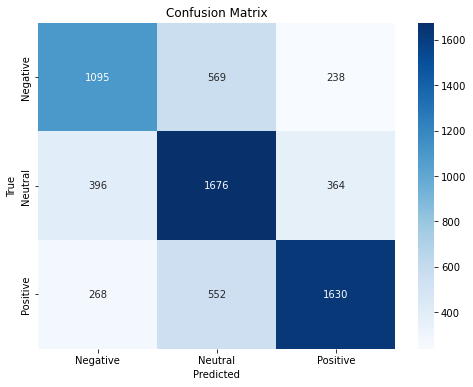

Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.58      0.60      1902
     Neutral       0.60      0.69      0.64      2436
    Positive       0.73      0.67      0.70      2450

    accuracy                           0.65      6788
   macro avg       0.65      0.64      0.65      6788
weighted avg       0.65      0.65      0.65      6788


Estimator: Logistic Regression with Tfidf

Metrics for Logistic Regression with Tfidf:
Accuracy: 0.649
Precision: 0.655
Recall: 0.649
F1 Score: 0.651


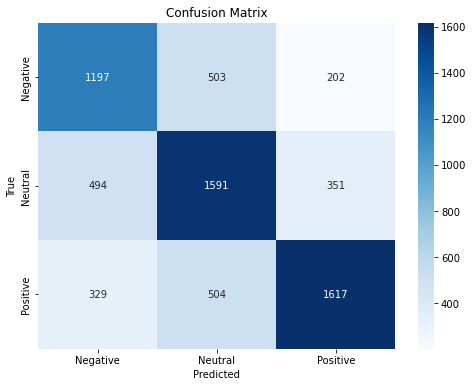

Classification Report:
              precision    recall  f1-score   support

    Negative       0.59      0.63      0.61      1902
     Neutral       0.61      0.65      0.63      2436
    Positive       0.75      0.66      0.70      2450

    accuracy                           0.65      6788
   macro avg       0.65      0.65      0.65      6788
weighted avg       0.65      0.65      0.65      6788


Estimator: Logistic Regression with w2v

Metrics for Logistic Regression with w2v:
Accuracy: 0.425
Precision: 0.430
Recall: 0.425
F1 Score: 0.425


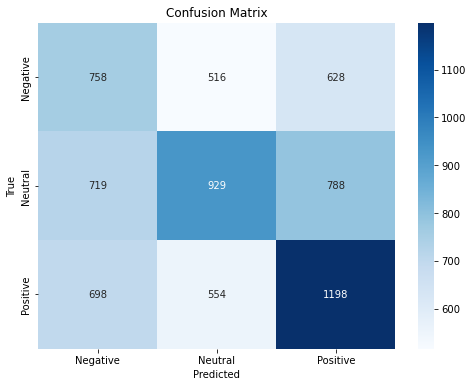

Classification Report:
              precision    recall  f1-score   support

    Negative       0.35      0.40      0.37      1902
     Neutral       0.46      0.38      0.42      2436
    Positive       0.46      0.49      0.47      2450

    accuracy                           0.43      6788
   macro avg       0.42      0.42      0.42      6788
weighted avg       0.43      0.43      0.43      6788


Estimator: Logistic Regression with d2v

Metrics for Logistic Regression with d2v:
Accuracy: 0.418
Precision: 0.422
Recall: 0.418
F1 Score: 0.419


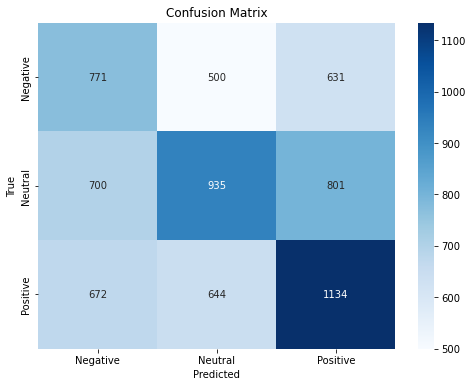

Classification Report:
              precision    recall  f1-score   support

    Negative       0.36      0.41      0.38      1902
     Neutral       0.45      0.38      0.41      2436
    Positive       0.44      0.46      0.45      2450

    accuracy                           0.42      6788
   macro avg       0.42      0.42      0.42      6788
weighted avg       0.42      0.42      0.42      6788


Estimator: Random Forest with CountVectorizer

Metrics for Random Forest with CountVectorizer:
Accuracy: 0.619
Precision: 0.635
Recall: 0.619
F1 Score: 0.610


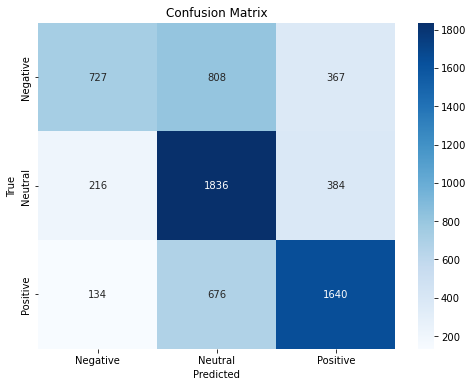

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.38      0.49      1902
     Neutral       0.55      0.75      0.64      2436
    Positive       0.69      0.67      0.68      2450

    accuracy                           0.62      6788
   macro avg       0.64      0.60      0.60      6788
weighted avg       0.64      0.62      0.61      6788


Estimator: Random Forest with Tfidf

Metrics for Random Forest with Tfidf:
Accuracy: 0.631
Precision: 0.641
Recall: 0.631
F1 Score: 0.625


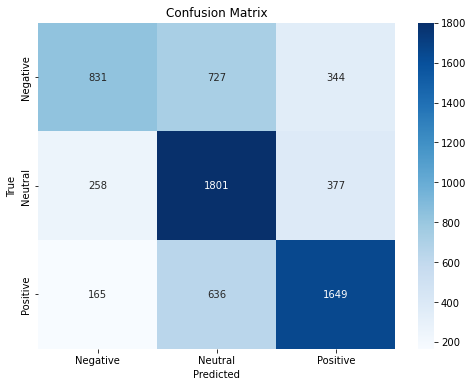

Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.44      0.53      1902
     Neutral       0.57      0.74      0.64      2436
    Positive       0.70      0.67      0.68      2450

    accuracy                           0.63      6788
   macro avg       0.64      0.62      0.62      6788
weighted avg       0.64      0.63      0.63      6788


Estimator: Random Forest with w2v

Metrics for Random Forest with w2v:
Accuracy: 0.488
Precision: 0.479
Recall: 0.488
F1 Score: 0.473


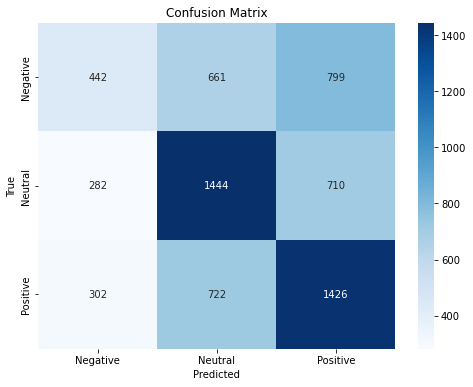

Classification Report:
              precision    recall  f1-score   support

    Negative       0.43      0.23      0.30      1902
     Neutral       0.51      0.59      0.55      2436
    Positive       0.49      0.58      0.53      2450

    accuracy                           0.49      6788
   macro avg       0.48      0.47      0.46      6788
weighted avg       0.48      0.49      0.47      6788


Estimator: Random Forest with d2v

Metrics for Random Forest with d2v:
Accuracy: 0.443
Precision: 0.435
Recall: 0.443
F1 Score: 0.429


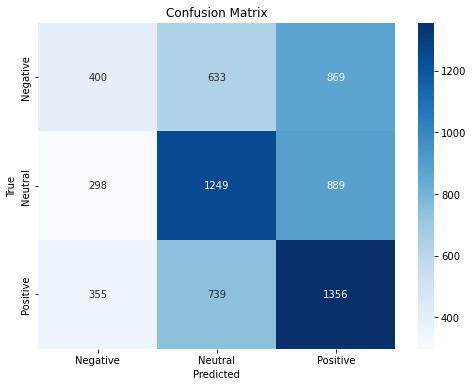

Classification Report:
              precision    recall  f1-score   support

    Negative       0.38      0.21      0.27      1902
     Neutral       0.48      0.51      0.49      2436
    Positive       0.44      0.55      0.49      2450

    accuracy                           0.44      6788
   macro avg       0.43      0.43      0.42      6788
weighted avg       0.43      0.44      0.43      6788



In [41]:
from sklearn.metrics import accuracy_score

for idx, gs in enumerate(pipeline_list):
    print('\nEstimator: %s' % pipeline_dict[idx])
    
    if pipeline_dict[idx] == 'Logistic Regression with w2v' or pipeline_dict[idx] == 'Random Forest with w2v':
        train_features1 = train_features_w2v
        test_features1 = test_features_w2v
    elif pipeline_dict[idx] == 'Logistic Regression with d2v' or pipeline_dict[idx] == 'Random Forest with d2v':
        train_features1 = train_sentence_vectors
        test_features1 = test_sentence_vectors
    else:
        train_features1 = np.array(train_features)
        test_features1 = np.array(test_features)
    
    gs.fit(train_features1, train_target)
    
    # Predict on test data with best params
    y_pred = gs.predict(test_features1)
    
    evaluate_and_visualize(pipeline_dict[idx], test_target, y_pred)
